In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parents[0]  # importing functions from other folders
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from _data.data_utils import read_in
from _fitting.fitting_utils import hist_plot, CI_plot, CI_plot_alt, CI_plot_both, plot_posteriors_side_by_side, plot_spline_Bknots
import pymc as pm
import pymc.math as pmm
import arviz as az
from patsy import dmatrix
import nutpie
import time
from IPython.display import display
from pymc.variational.callbacks import CheckParametersConvergence
import io
import base64
import seaborn as sns

az.style.use("arviz-darkgrid")


if '___laptop' in os.listdir('../'):
    # laptop folder
    folder = "../../_data/p-dengue/"
elif '___server' in os.listdir('../'):
    # server folder
    folder = "../../../../../data/lucaratzinger_data/p_dengue/"

In [2]:
import pyreadr
data_folder = folder
admin2_year_month_cases  = pyreadr.read_r(os.path.join(data_folder, 'cases_deaths_pop_2016_2024_38.rds'))[None]

In [3]:
admin2_year_month_cases['region'].unique()

array(['SUMATRA', 'JAVA & BALI', 'NUSA TENGGARA', 'KALIMANTAN',
       'SULAWESI', 'MALUKU', 'PAPUA'], dtype=object)

In [4]:
# use region and admin1 to create a dictionary mapping admin1 to region it belongs to
admin1_to_region = {}
for _, row in admin2_year_month_cases.iterrows():
    admin1 = row['admin1']
    region = row['region']
    admin1_to_region[admin1] = region

In [5]:
data = read_in(folder, admin=2, max_lag=6, dropna=True, end_year=2024, end_month=12)
data['date'] = pd.to_datetime(data['year'].astype(str) + '-' + data['month'].astype(str) + '-01')

In [6]:
data

,admin1,admin2,year,month,cases,ONI,t2m_mean_unweighted(0),t2m_mean_pop_weighted(0),t2m_min_unweighted(0),t2m_min_pop_weighted(0),...,urban_surveillance_nonweighted,urban_surveillance_pop_weighted,density_unweighted,density_pop_weighted,urban_density_unweighted,urban_density_pop_weighted,urbanisation_nonweighted_std,urbanisation_pop_weighted_std,ONI_std,date
0,ACEH,SIMEULUE,2016,1,1.0,2.48,27.17922,27.197840,24.47756,24.526417,...,0.774953,0.768781,42.316379,715.475930,296.269231,1066.646631,-0.77511,-1.449924,2.992386,2016-01-01
1,ACEH,SIMEULUE,2016,2,8.0,2.14,27.36236,27.382226,24.75063,24.775451,...,0.774953,0.768781,42.316379,715.475930,296.269231,1066.646631,-0.77511,-1.449924,2.586619,2016-02-01
2,ACEH,SIMEULUE,2016,3,9.0,1.58,27.37810,27.401347,24.88680,24.928477,...,0.774953,0.768781,42.316379,715.475930,296.269231,1066.646631,-0.77511,-1.449924,1.918299,2016-03-01
3,ACEH,SIMEULUE,2016,4,14.0,0.94,27.39373,27.415193,25.11874,25.147523,...,0.774953,0.768781,42.316379,715.475930,296.269231,1066.646631,-0.77511,-1.449924,1.154503,2016-04-01
4,ACEH,SIMEULUE,2016,5,4.0,0.39,27.50067,27.520510,25.18392,25.223199,...,0.774953,0.768781,42.316379,715.475930,296.269231,1066.646631,-0.77511,-1.449924,0.498117,2016-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55507,PAPUA,KOTA JAYAPURA,2024,8,8.0,-0.11,25.74790,25.918357,22.70297,22.875526,...,0.843776,0.874028,424.647959,14869.435665,3627.737374,17003.582738,-0.47457,1.107569,-0.098598,2024-08-01
55508,PAPUA,KOTA JAYAPURA,2024,9,0.0,-0.21,26.05120,26.183588,22.68896,22.831706,...,0.843776,0.874028,424.647959,14869.435665,3627.737374,17003.582738,-0.47457,1.107569,-0.217941,2024-09-01
55509,PAPUA,KOTA JAYAPURA,2024,10,24.0,-0.26,25.86794,26.034049,22.81628,22.964368,...,0.843776,0.874028,424.647959,14869.435665,3627.737374,17003.582738,-0.47457,1.107569,-0.277613,2024-10-01
55510,PAPUA,KOTA JAYAPURA,2024,11,57.0,-0.37,26.09180,26.242261,22.76202,22.958716,...,0.843776,0.874028,424.647959,14869.435665,3627.737374,17003.582738,-0.47457,1.107569,-0.408890,2024-11-01


In [7]:
weather_columns = [c for c in data.columns if c.endswith(')')]
# tp columns
weather_columns = [c for c in weather_columns if not (c.startswith('tp') and not ('_log' not in c or 'log1p' in c))]
weather_columns = [c for c in weather_columns if not (c.startswith('tp') and 'log1p' in c)]
# pop_weighted
weather_columns = [c for c in weather_columns if 'pop_weighted' in c]

# sort columns by name
weather_columns = sorted(weather_columns)

data = data[weather_columns + ['admin1', 'admin2', 'cases', 'year', 'month', 'population']]

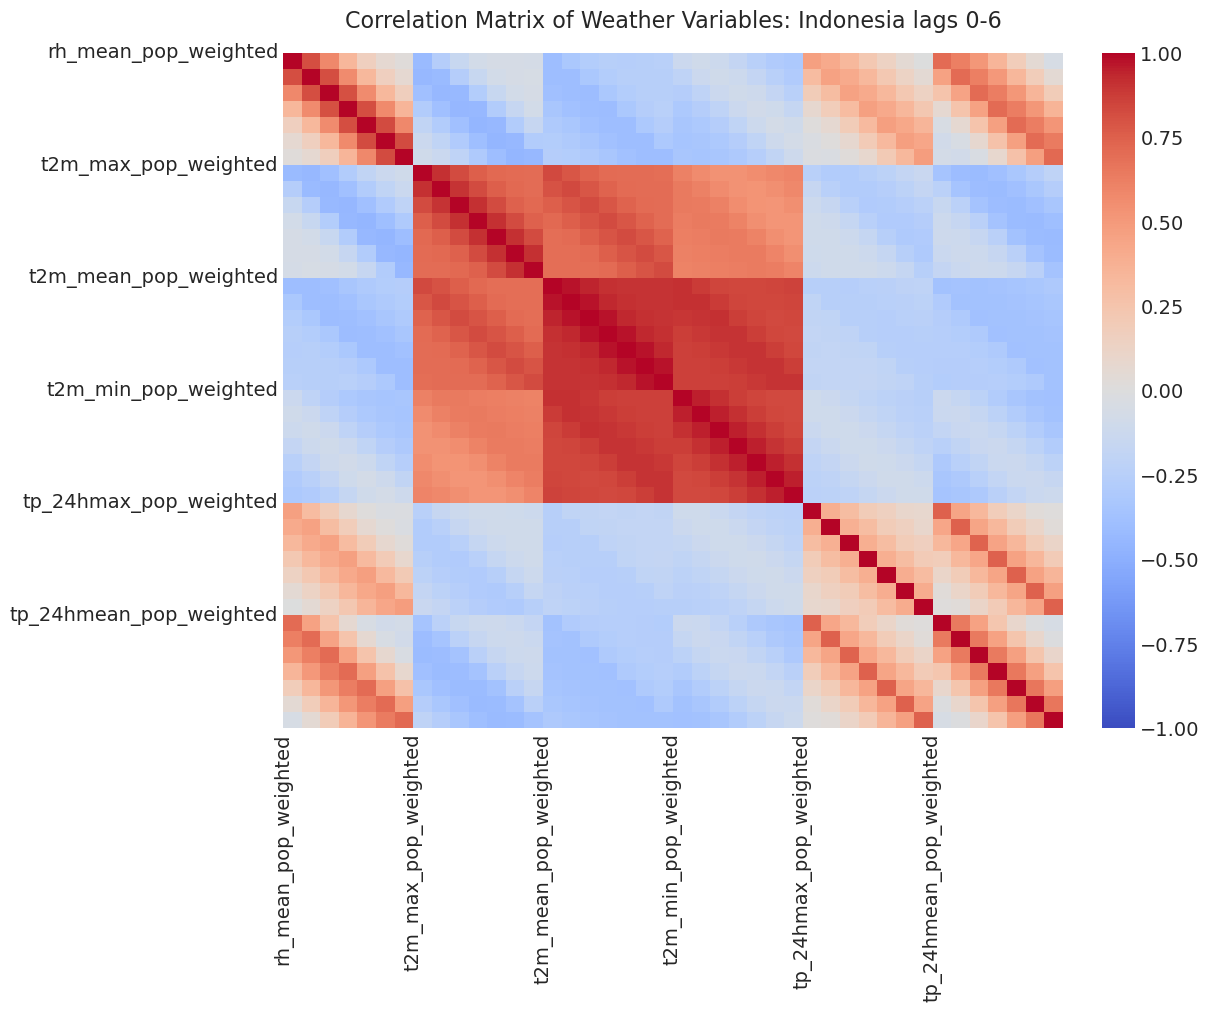

In [17]:
# use seaborn to plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(data[weather_columns].corr(), annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Weather Variables: Indonesia lags 0-6', y=1.025)
# instead of using all column names, use only every sixth column name, and remove the lag number
xticks = [i for i in range(len(weather_columns)) if i % 7 == 0]
xtick_labels = [weather_columns[i].split('(')[0] for i in xticks]
plt.xticks(xticks, xtick_labels, rotation=90)
yticks = [i for i in range(len(weather_columns)) if i % 7 == 0]
ytick_labels = [weather_columns[i].split('(')[0] for i in yticks]
plt.yticks(yticks, ytick_labels, rotation=0)
# can you shift the ticks a bit to the right and downwards so they are not on the grid lines?
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True, labeltop=False, labelrotation=90)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=True, labelright=False)
plt.show()

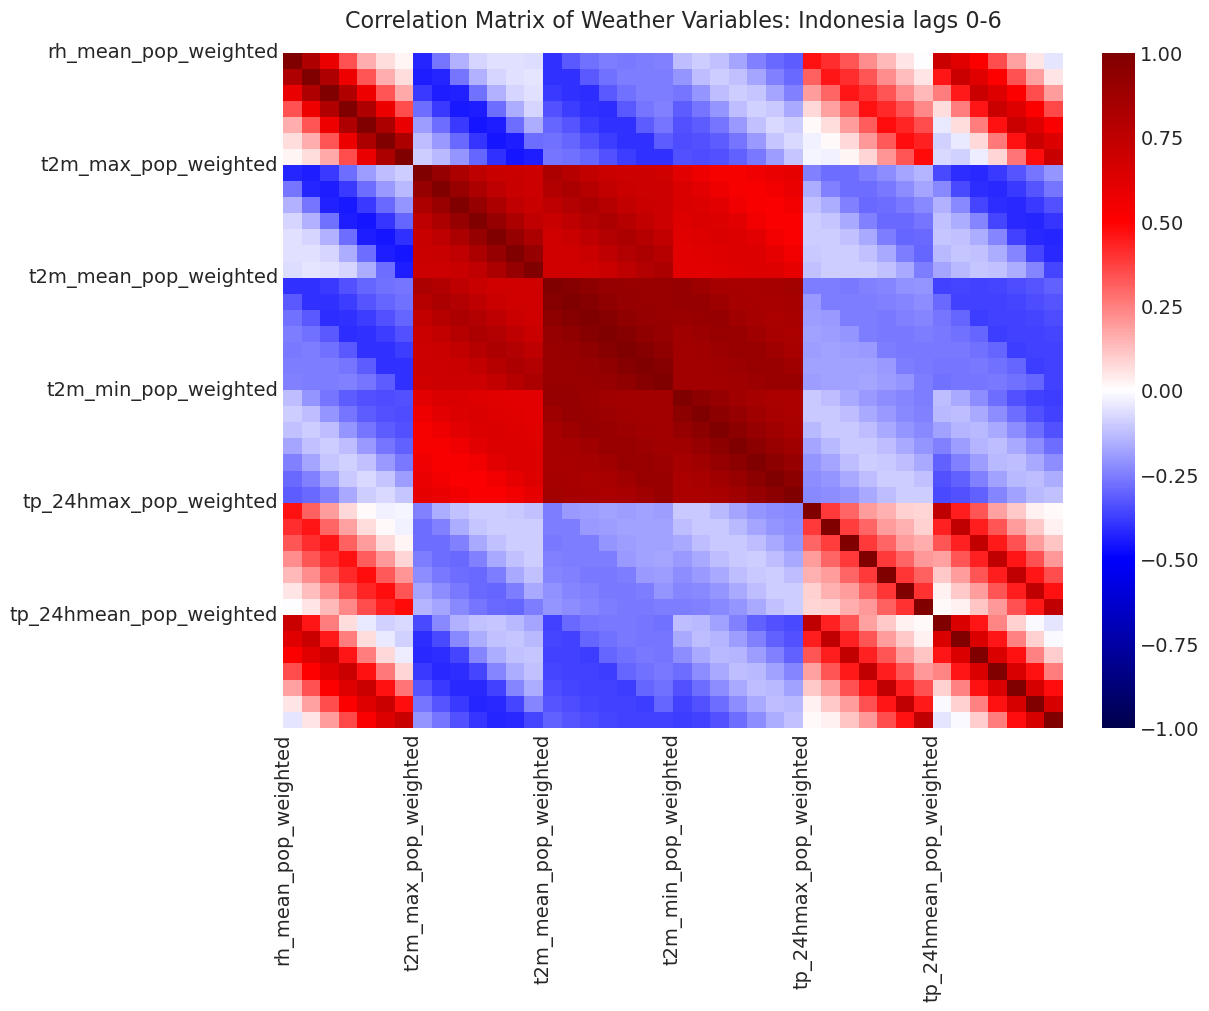

In [18]:
# use seaborn to plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(data[weather_columns].corr(), annot=False, cmap='seismic', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Weather Variables: Indonesia lags 0-6', y=1.025)
# instead of using all column names, use only every sixth column name, and remove the lag number
xticks = [i for i in range(len(weather_columns)) if i % 7 == 0]
xtick_labels = [weather_columns[i].split('(')[0] for i in xticks]
plt.xticks(xticks, xtick_labels, rotation=90)
yticks = [i for i in range(len(weather_columns)) if i % 7 == 0]
 
ytick_labels = [weather_columns[i].split('(')[0] for i in yticks]
plt.yticks(yticks, ytick_labels, rotation=0)
# can you shift the ticks a bit to the right and downwards so they are not on the grid lines?
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True, labeltop=False, labelrotation=90)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=True, labelright=False)
plt.show()

- relative humidity (rh): shows positive autocorrelation with lag up to 3/4, then zero
- total precipitation (tp): max shows weaker autocorrelation, mean shows greater autocorrelation positive up to lag3, then zero or slightly negative for tp_mean. Correlation between max and mean is marked but not super strong
- temperature (t2m): strong autocorrelation up to lag 6, mean and min show highest autocorrelation, max a bit less. mean and min are very correlated, max less so.

rh-t2m: negative.
- rh-t2m_max: sharp. negative strongest on diagonal and above (rh of previous month), then goes to zero
- rh-t2m_mean: more diffuse, strong
- rh-t2m_min: less strong on diagonal and below (rh of next month), stronger outside

rh-tp: positive.
- rh-tp_max: less strong. strong on diagonal and above (rh of previous month), goes to zero
- rh-tp_mean: strong on diagonal and above (rh of previous month), goes to slightly negative

t2m-tp: negative. stronger on tp_mean (possibly because tp_max has higher variability)
- t2m_max-tp_mean: strong on diagonal and two above diagonal (mean precipitation 1 and 2 months prior is strongly negatively correlated with mean temperature). Correlation with future rainfall is weaker.
- t2m_mean-tp_mean: less trong and more diffuse than t2m_max so that negative correlation is not as strong on the diagonal or above, but remains stronger, especially with future rainfall
- t2m_min-tp_mean: nearly uncorrelated on diagonal, negative at the edges (min temperature and tp have strong negative correlation at 5-6 month lag)

---

How much is explained by ciclicity? (subtract month average)

In [10]:
# copy original
data_anom = data.copy()

# monthly climatology per admin2
clim = data.groupby(['admin2', 'month'])[weather_columns].mean().reset_index()
clim = clim.rename(columns={c: f"{c}_clim" for c in weather_columns})

# merge climatology back and compute anomalies
data_anom = data_anom.merge(clim, on=['admin2', 'month'], how='left')
for c in weather_columns:
    data_anom[f'{c}_anom'] = data_anom[c] - data_anom[f'{c}_clim']

data_anom.head()

,rh_mean_pop_weighted(0),rh_mean_pop_weighted(1),rh_mean_pop_weighted(2),rh_mean_pop_weighted(3),rh_mean_pop_weighted(4),rh_mean_pop_weighted(5),rh_mean_pop_weighted(6),t2m_max_pop_weighted(0),t2m_max_pop_weighted(1),t2m_max_pop_weighted(2),...,tp_24hmax_pop_weighted(4)_anom,tp_24hmax_pop_weighted(5)_anom,tp_24hmax_pop_weighted(6)_anom,tp_24hmean_pop_weighted(0)_anom,tp_24hmean_pop_weighted(1)_anom,tp_24hmean_pop_weighted(2)_anom,tp_24hmean_pop_weighted(3)_anom,tp_24hmean_pop_weighted(4)_anom,tp_24hmean_pop_weighted(5)_anom,tp_24hmean_pop_weighted(6)_anom
0,84.161983,85.572814,86.802672,86.283609,85.488271,84.176874,83.818983,30.487601,29.371063,29.102620,...,-0.005350,-0.010824,-0.020759,0.000642,0.000717,0.002834,0.000504,0.001688,-0.000641,-0.000595
1,83.107763,84.161983,85.572814,86.802672,86.283609,85.488271,84.176874,29.756625,30.487601,29.371063,...,0.015370,-0.005350,-0.010824,0.000768,0.000642,0.000717,0.002834,0.000504,0.001688,-0.000641
2,84.545830,83.107763,84.161983,85.572814,86.802672,86.283609,85.488271,30.366854,29.756625,30.487601,...,0.013551,0.015370,-0.005350,0.002880,0.000768,0.000642,0.000717,0.002834,0.000504,0.001688
3,85.093259,84.545830,83.107763,84.161983,85.572814,86.802672,86.283609,29.991070,30.366854,29.756625,...,0.008079,0.013551,0.015370,0.000603,0.002880,0.000768,0.000642,0.000717,0.002834,0.000504
4,84.329681,85.093259,84.545830,83.107763,84.161983,85.572814,86.802672,30.830211,29.991070,30.366854,...,-0.003749,0.008079,0.013551,0.002302,0.000603,0.002880,0.000768,0.000642,0.000717,0.002834


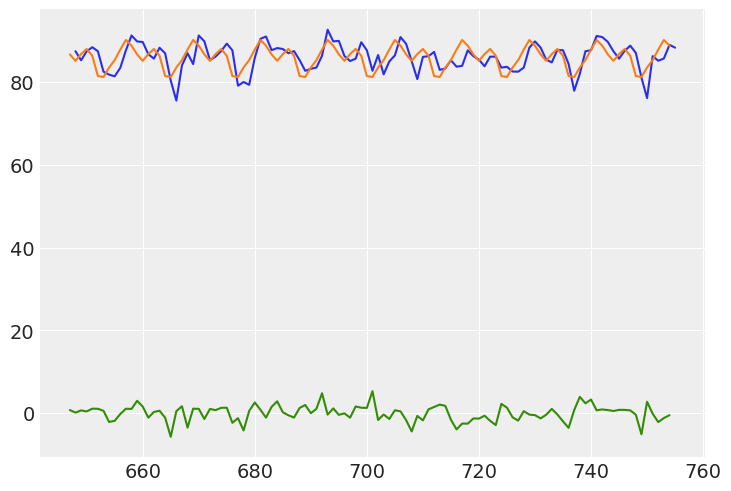

In [11]:
plt.plot(data.loc[data['admin2'] == 'ACEH BARAT']['rh_mean_pop_weighted(0)'])
plt.plot(data_anom.loc[data_anom['admin2'] == 'ACEH BARAT']['rh_mean_pop_weighted(0)_clim'])
plt.plot(data_anom.loc[data_anom['admin2'] == 'ACEH BARAT']['rh_mean_pop_weighted(0)_anom'])

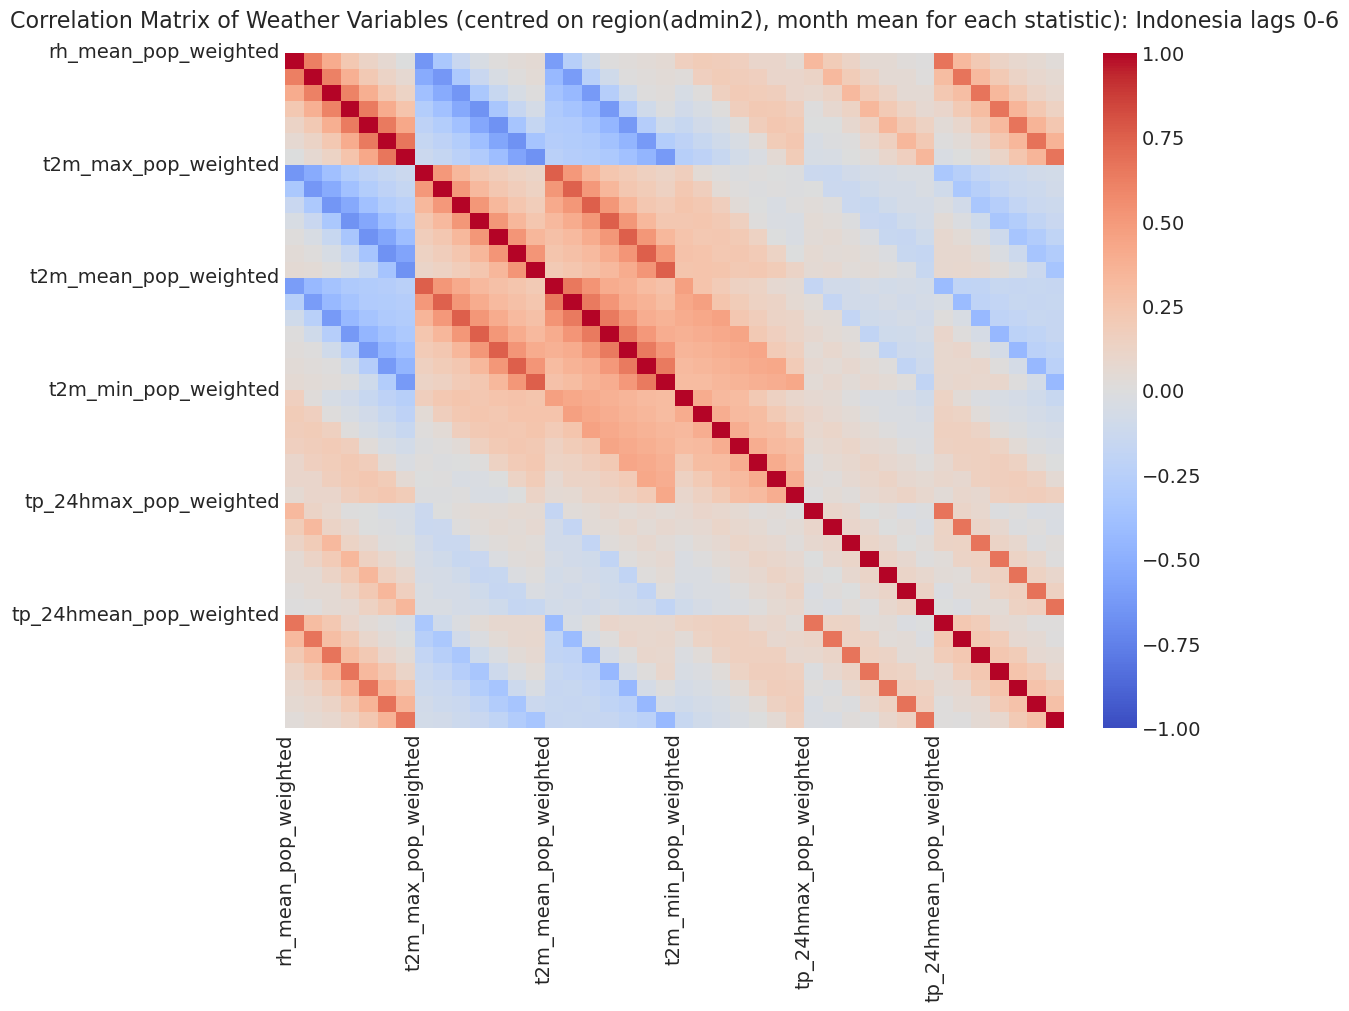

In [19]:
# use seaborn to plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(data_anom[[w + '_anom' for w in weather_columns]].corr(), annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Weather Variables (centred on region(admin2), month mean for each statistic): Indonesia lags 0-6', y=1.025)
# instead of using all column names, use only every sixth column name, and remove the lag number
xticks = [i for i in range(len(weather_columns)) if i % 7 == 0]
xtick_labels = [weather_columns[i].split('(')[0] for i in xticks]
plt.xticks(xticks, xtick_labels, rotation=90)
yticks = [i for i in range(len(weather_columns)) if i % 7 == 0]
ytick_labels = [weather_columns[i].split('(')[0] for i in yticks]
plt.yticks(yticks, ytick_labels, rotation=0)
# can you shift the ticks a bit to the right and downwards so they are not on the grid lines?
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True, labeltop=False, labelrotation=90)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=True, labelright=False)
plt.show()

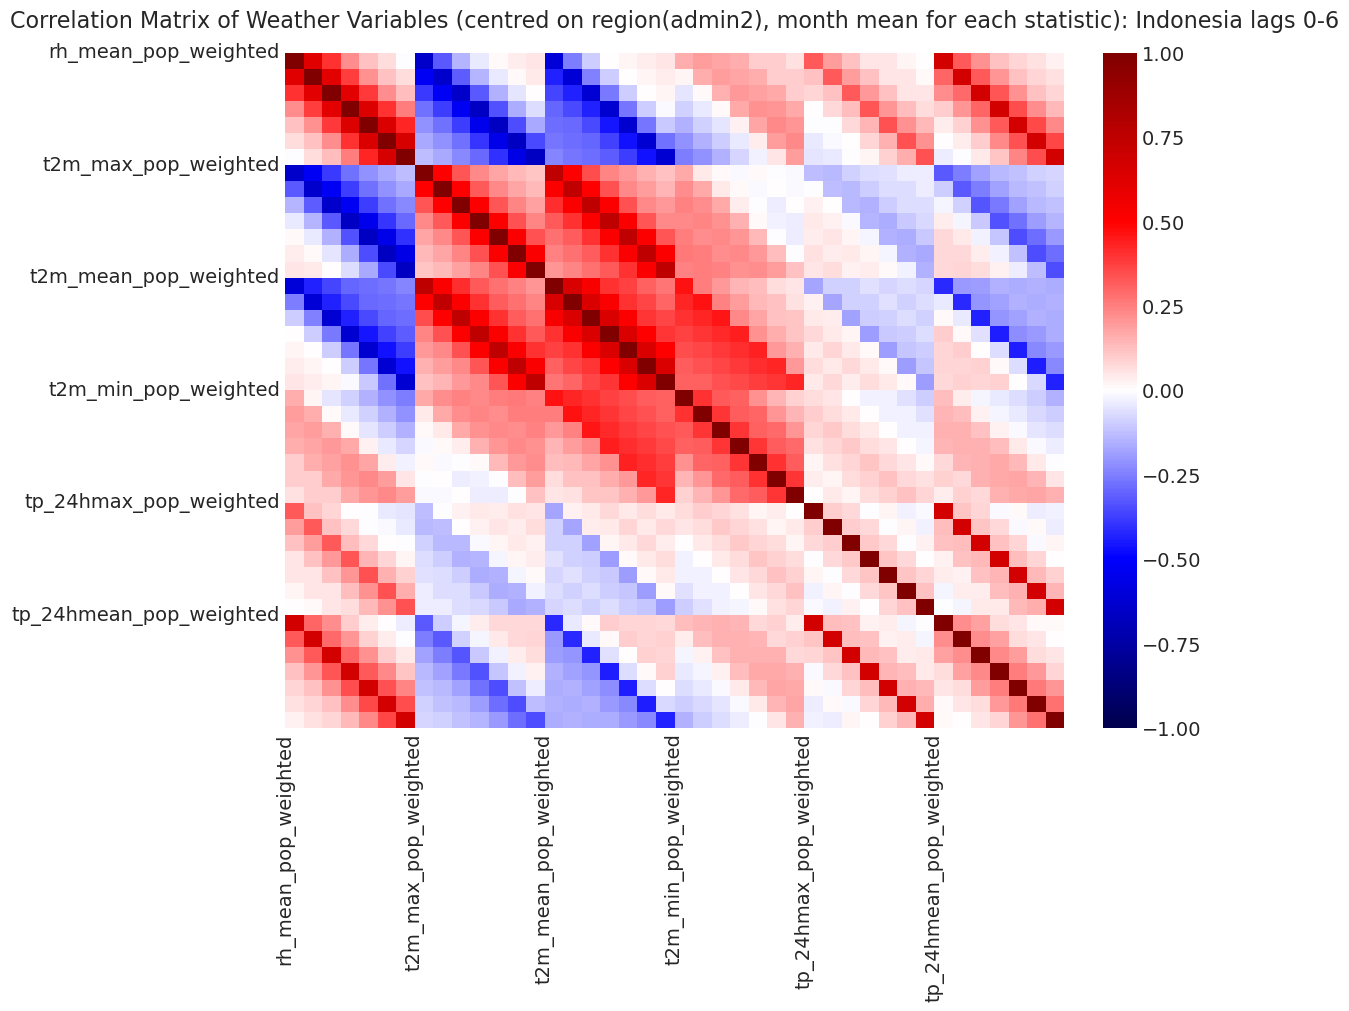

In [21]:
# use seaborn to plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(data_anom[[w + '_anom' for w in weather_columns]].corr(), annot=False, cmap='seismic', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Weather Variables (centred on region(admin2), month mean for each statistic): Indonesia lags 0-6', y=1.025)
# instead of using all column names, use only every sixth column name, and remove the lag number
xticks = [i for i in range(len(weather_columns)) if i % 7 == 0]
xtick_labels = [weather_columns[i].split('(')[0] for i in xticks]
plt.xticks(xticks, xtick_labels, rotation=90)
yticks = [i for i in range(len(weather_columns)) if i % 7 == 0]
 
ytick_labels = [weather_columns[i].split('(')[0] for i in yticks]
plt.yticks(yticks, ytick_labels, rotation=0)
# can you shift the ticks a bit to the right and downwards so they are not on the grid lines?
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True, labeltop=False, labelrotation=90)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=True, labelright=False)
plt.show()

This has lower values than the previous matrix so annual cycle was accounting for some correlation. The values are now deviations from the region_month mean.

---

## Correlations by region

- Correlation matrices for each region, in batches

In [22]:
a2_regions = sorted(data['admin2'].unique())
anom_cols = [c + "_anom" for c in weather_columns]

In [14]:
# batch and save covariance heatmaps into 4 separate folders (one per cmap/anom combination)
cols = 4
rows = 16
n_plots = cols * rows
batch_size = 64

out_dirs = {
    "non_anom_coolwarm": "cov_non_anom_coolwarm",
    "non_anom_seismic": "cov_non_anom_seismic",
    "anom_coolwarm": "cov_anom_coolwarm",
    "anom_seismic": "cov_anom_seismic",
}
for d in out_dirs.values():
    os.makedirs(d, exist_ok=True)

def make_figure(df, cols_list, cmap, regions_batch, out_fn):
    vmin, vmax = -1, 1
    fig_w = cols * 3
    fig_h = rows * 1.6
    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h))
    axes = axes.flatten()
    for i in range(n_plots):
        ax = axes[i]
        if i < len(regions_batch):
            r = regions_batch[i]
            sub = df.loc[df['admin2'] == r, cols_list].dropna()
            if sub.shape[0] >= 2:
                cov = sub.corr()
                sns.heatmap(cov, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax,
                            xticklabels=False, yticklabels=False, cbar=False)
            else:
                ax.text(0.5, 0.5, "insufficient\nrows", ha='center', va='center', fontsize=6)
                ax.set_xticks([]); ax.set_yticks([])
            ax.set_title(r, fontsize=6, pad=1)
        else:
            ax.axis('off')
    fig.savefig(out_fn, dpi=300, bbox_inches='tight')
    plt.close(fig)

n_batches = int(np.ceil(len(a2_regions) / batch_size))
for b in range(n_batches):
    batch_regions = a2_regions[b*batch_size:(b+1)*batch_size]
    idx = b + 1
    # non-anom coolwarm
    make_figure(data, weather_columns, cmap="coolwarm", regions_batch=batch_regions,
                out_fn=os.path.join(out_dirs["non_anom_coolwarm"], f"cov_non_anom_coolwarm_batch{idx:02d}.png"))
    # non-anom seismic
    make_figure(data, weather_columns, cmap="seismic", regions_batch=batch_regions,
                out_fn=os.path.join(out_dirs["non_anom_seismic"], f"cov_non_anom_seismic_batch{idx:02d}.png"))
    # anom coolwarm
    make_figure(data_anom, anom_cols, cmap="coolwarm", regions_batch=batch_regions,
                out_fn=os.path.join(out_dirs["anom_coolwarm"], f"cov_anom_coolwarm_batch{idx:02d}.png"))
    # anom seismic
    make_figure(data_anom, anom_cols, cmap="seismic", regions_batch=batch_regions,
                out_fn=os.path.join(out_dirs["anom_seismic"], f"cov_anom_seismic_batch{idx:02d}.png"))

- admin2 correlations by admin1

In [15]:
# Group covariance heatmaps by admin1: one figure per admin1 with subplots for each admin2 in that admin1
# Uses existing variables: data, data_anom, weather_columns, sns, plt, os, rows, cols

cols = 4
cmaps = {"coolwarm": "non_anom_coolwarm"} ##, "seismic": "non_anom_seismic"}
anom_cmaps = {} ##{"coolwarm": "anom_coolwarm", "seismic": "anom_seismic"}

out_base = "corr_by_admin1"
for d in [out_base]:
    os.makedirs(d, exist_ok=True)
for v in list(cmaps.values()) + list(anom_cmaps.values()):
    os.makedirs(os.path.join(out_base, v), exist_ok=True)

anom_cols = [c + "_anom" for c in weather_columns]

def safe_fn(s):
    return "".join(ch if ch.isalnum() or ch in "-_" else "_" for ch in s).strip("_").lower()

def make_admin1_figure(df, cols_list, cmap, admin1_name, out_fn):
    admin2_list = sorted(df.loc[df['admin1'] == admin1_name, 'admin2'].unique())
    n = len(admin2_list)
    if n == 0:
        return
    rows = max(1, int(np.ceil(n / cols)))
    fig_w = cols * 3
    fig_h = rows * 1.6
    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h))
    axes = np.array(axes).reshape(-1)
    vmin, vmax = -1, 1
    for i, ax in enumerate(axes):
        if i < n:
            r = admin2_list[i]
            sub = df.loc[df['admin2'] == r, cols_list].dropna()
            if sub.shape[0] >= 2:
                cov = sub.corr()
                sns.heatmap(cov, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax,
                            xticklabels=False, yticklabels=False, cbar=False)
            else:
                ax.text(0.5, 0.5, "insufficient\nrows", ha='center', va='center', fontsize=6)
                ax.set_xticks([]); ax.set_yticks([])
            ax.set_title(r, fontsize=6, pad=1)
        else:
            ax.axis('off')
    fig.suptitle(f"{admin1_name} — {os.path.basename(out_fn)}", fontsize=10)
    fig.savefig(out_fn, dpi=300, bbox_inches='tight')
    plt.close(fig)

admin1_list = sorted(data['admin1'].unique())

for admin1_name in admin1_list:
    fn_base = safe_fn(admin1_name)
    # non-anom maps
    for cmap, subdir in cmaps.items():
        out_fn = os.path.join(out_base, subdir, f"{fn_base}_non_anom_{cmap}.png")
        make_admin1_figure(data, weather_columns, cmap, admin1_name, out_fn)
    # anom maps
    for cmap, subdir in anom_cmaps.items():
        out_fn = os.path.join(out_base, subdir, f"{fn_base}_anom_{cmap}.png")
        make_admin1_figure(data_anom, anom_cols, cmap, admin1_name, out_fn)

- admin2 covariances (scaling each weather statistic) by admin1

In [23]:
data_temp = data.copy()
data_anom_temp = data_anom.copy()

scaled_data = data.copy()
for c in weather_columns:
    scaled_data[c] = (data_temp[c] - data_temp[c].mean()) / data_temp[c].std()
for c in anom_cols:
    scaled_data[c] = (data_anom_temp[c] - data_anom_temp[c].mean()) / data_anom_temp[c].std()

In [24]:
# compute global vmin/vmax of covariances across admin2, then make covariance heatmap figures
# instead of min and max of covariance matrices, use 5 and 95 percentiles
    

regions_list = data['admin2'].unique()
def compute_cov_range_quantile(df, cols_list, regs, q_low=0.05, q_high=0.95):
    all_cov_values = np.array([])
    for r in regs:
        sub = df.loc[df['admin2'] == r, cols_list].dropna()
        if sub.shape[0] >= 2:
            cov = sub.cov().values
            # concatenate all finite covariance values into a 1D array
            cov_values = cov[np.isfinite(cov)].flatten()
            all_cov_values = np.concatenate((all_cov_values, cov_values))
    q_low_val = np.nanquantile(all_cov_values, q_low)
    q_high_val = np.nanquantile(all_cov_values, q_high)
    return q_low_val, q_high_val

def compute_cov_range_min_max(df, cols_list, regs):
    all_cov_values = np.array([])
    for r in regs:
        sub = df.loc[df['admin2'] == r, cols_list].dropna()
        if sub.shape[0] >= 2:
            cov = sub.cov().values
            # concatenate all finite covariance values into a 1D array
            cov_values = cov[np.isfinite(cov)].flatten()
            all_cov_values = np.concatenate((all_cov_values, cov_values))
    mn = np.nanmin(all_cov_values)
    mx = np.nanmax(all_cov_values)
    return mn, mx


vql_non, vqh_non = compute_cov_range_quantile(scaled_data, weather_columns, regions_list, q_low=0.05, q_high=0.95)
vql_anom, vqh_anom = compute_cov_range_quantile(scaled_data, anom_cols, regions_list, q_low=0.05, q_high=0.95)

vmin_non, vmax_non = compute_cov_range_min_max(scaled_data, weather_columns, regions_list)
vmin_anom, vmax_anom = compute_cov_range_min_max(scaled_data, anom_cols, regions_list)

In [25]:
vql_non, vqh_non, vmin_non, vmax_non

(np.float64(-0.22567518131128314),
 np.float64(0.38720489477729336),
 np.float64(-3.2589891800329878),
 np.float64(4.532929739542077))

In [26]:
# Group covariance heatmaps by admin1: one figure per admin1 with subplots for each admin2 in that admin1
# Uses existing variables: data, data_anom, weather_columns, sns, plt, os, rows, cols

cols = 4
cmaps = {"coolwarm": "non_anom_coolwarm"} ##, "seismic": "non_anom_seismic"}
anom_cmaps = {} ##{"coolwarm": "anom_coolwarm", "seismic": "anom_seismic"}

out_base = "scaled_cov_by_admin1"
for d in [out_base]:
    os.makedirs(d, exist_ok=True)
for v in list(cmaps.values()) + list(anom_cmaps.values()):
    os.makedirs(os.path.join(out_base, v), exist_ok=True)

anom_cols = [c + "_anom" for c in weather_columns]

def safe_fn(s):
    return "".join(ch if ch.isalnum() or ch in "-_" else "_" for ch in s).strip("_").lower()

from matplotlib import colors as mcolors

def make_admin1_figure(df, cols_list, cmap, admin1_name, out_fn, vmin, vmax):
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    admin2_list = sorted(df.loc[df['admin1'] == admin1_name, 'admin2'].unique())
    n = len(admin2_list)
    if n == 0:
        return
    rows = max(1, int(np.ceil(n / cols)))
    fig_w = cols * 3
    fig_h = rows * 1.6
    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h))
    axes = np.array(axes).reshape(-1)
    for i, ax in enumerate(axes):
        if i < n:
            r = admin2_list[i]
            sub = df.loc[df['admin2'] == r, cols_list].dropna()
            if sub.shape[0] >= 2:
                cov = sub.cov()
                sns.heatmap(cov, ax=ax, cmap=cmap, norm=norm,
                            xticklabels=False, yticklabels=False, cbar=False)
            else:
                ax.text(0.5, 0.5, "insufficient\nrows", ha='center', va='center', fontsize=6)
                ax.set_xticks([]); ax.set_yticks([])
            ax.set_title(r, fontsize=6, pad=1)
        else:
            ax.axis('off')
    fig.suptitle(f"{admin1_name} — {os.path.basename(out_fn)}", fontsize=10)
    fig.savefig(out_fn, dpi=300, bbox_inches='tight')
    plt.close(fig)

admin1_list = sorted(data['admin1'].unique())

for admin1_name in admin1_list:
    fn_base = safe_fn(admin1_name)
    # non-anom maps
    for cmap, subdir in cmaps.items():
        out_fn = os.path.join(out_base, subdir, f"{fn_base}_non_anom_{cmap}.png")
        make_admin1_figure(scaled_data, weather_columns, cmap, admin1_name, out_fn, vql_non, vqh_non)
    # anom maps
    for cmap, subdir in anom_cmaps.items():
        out_fn = os.path.join(out_base, subdir, f"{fn_base}_anom_{cmap}.png")
        make_admin1_figure(scaled_data, anom_cols, cmap, admin1_name, out_fn, vql_anom, vqh_anom)

---
## incidence - weather response

In [27]:
data.columns

Index(['rh_mean_pop_weighted(0)', 'rh_mean_pop_weighted(1)',
       'rh_mean_pop_weighted(2)', 'rh_mean_pop_weighted(3)',
       'rh_mean_pop_weighted(4)', 'rh_mean_pop_weighted(5)',
       'rh_mean_pop_weighted(6)', 't2m_max_pop_weighted(0)',
       't2m_max_pop_weighted(1)', 't2m_max_pop_weighted(2)',
       't2m_max_pop_weighted(3)', 't2m_max_pop_weighted(4)',
       't2m_max_pop_weighted(5)', 't2m_max_pop_weighted(6)',
       't2m_mean_pop_weighted(0)', 't2m_mean_pop_weighted(1)',
       't2m_mean_pop_weighted(2)', 't2m_mean_pop_weighted(3)',
       't2m_mean_pop_weighted(4)', 't2m_mean_pop_weighted(5)',
       't2m_mean_pop_weighted(6)', 't2m_min_pop_weighted(0)',
       't2m_min_pop_weighted(1)', 't2m_min_pop_weighted(2)',
       't2m_min_pop_weighted(3)', 't2m_min_pop_weighted(4)',
       't2m_min_pop_weighted(5)', 't2m_min_pop_weighted(6)',
       'tp_24hmax_pop_weighted(0)', 'tp_24hmax_pop_weighted(1)',
       'tp_24hmax_pop_weighted(2)', 'tp_24hmax_pop_weighted(3)',
       't

In [28]:
data = read_in(folder, admin=2, max_lag=6, dropna=True, start_year=2016, start_month=6, end_year=2024, end_month=12)
data['date'] = pd.to_datetime(data['year'].astype(str) + '-' + data['month'].astype(str) + '-01')

In [29]:
data['rate'] = data['cases'] / data['population']

In [30]:
palette = 'blue'
if palette=='blue':
    color_95 = "#c3ceee"   # very light blue
    color_90 = "#95b8db"   # light blue
    color_75 = "#2777b0"   # medium blue
    median_color = '#08519c'
    mean_color = '#de2d26'
elif palette=='red':
    color_95 = '#fee5d9'   # very light red
    color_90 = '#fcbba1'   # light red
    color_75 = '#fb6a4a'   # medium red
    median_color = '#cb181d'
    mean_color = '#08519c'
elif palette=='purple':
    color_95 = '#f2f0f7'   # very light purple
    color_90 = '#e7e1ef'   # light purple
    color_75 = '#9e9ac8'   # medium purple
    median_color = '#6a51a3'
    mean_color = '#de2d26'
elif palette=='green':
    color_95 = '#edf8e9'   # very light green
    color_90 = '#c7e9c0'   # light green
    color_75 = '#74c476'   # medium green
    median_color = '#238b45'
    mean_color = '#de2d26'


In [32]:
d_g0 = data.loc[data['rate'] > 0, :].copy()
d_g0 = data.copy()
# d_g0['rate'] = np.sqrt(np.sqrt(d_g0['rate']))
#

/tmp/ipykernel_2441170/1478824358.py:135: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


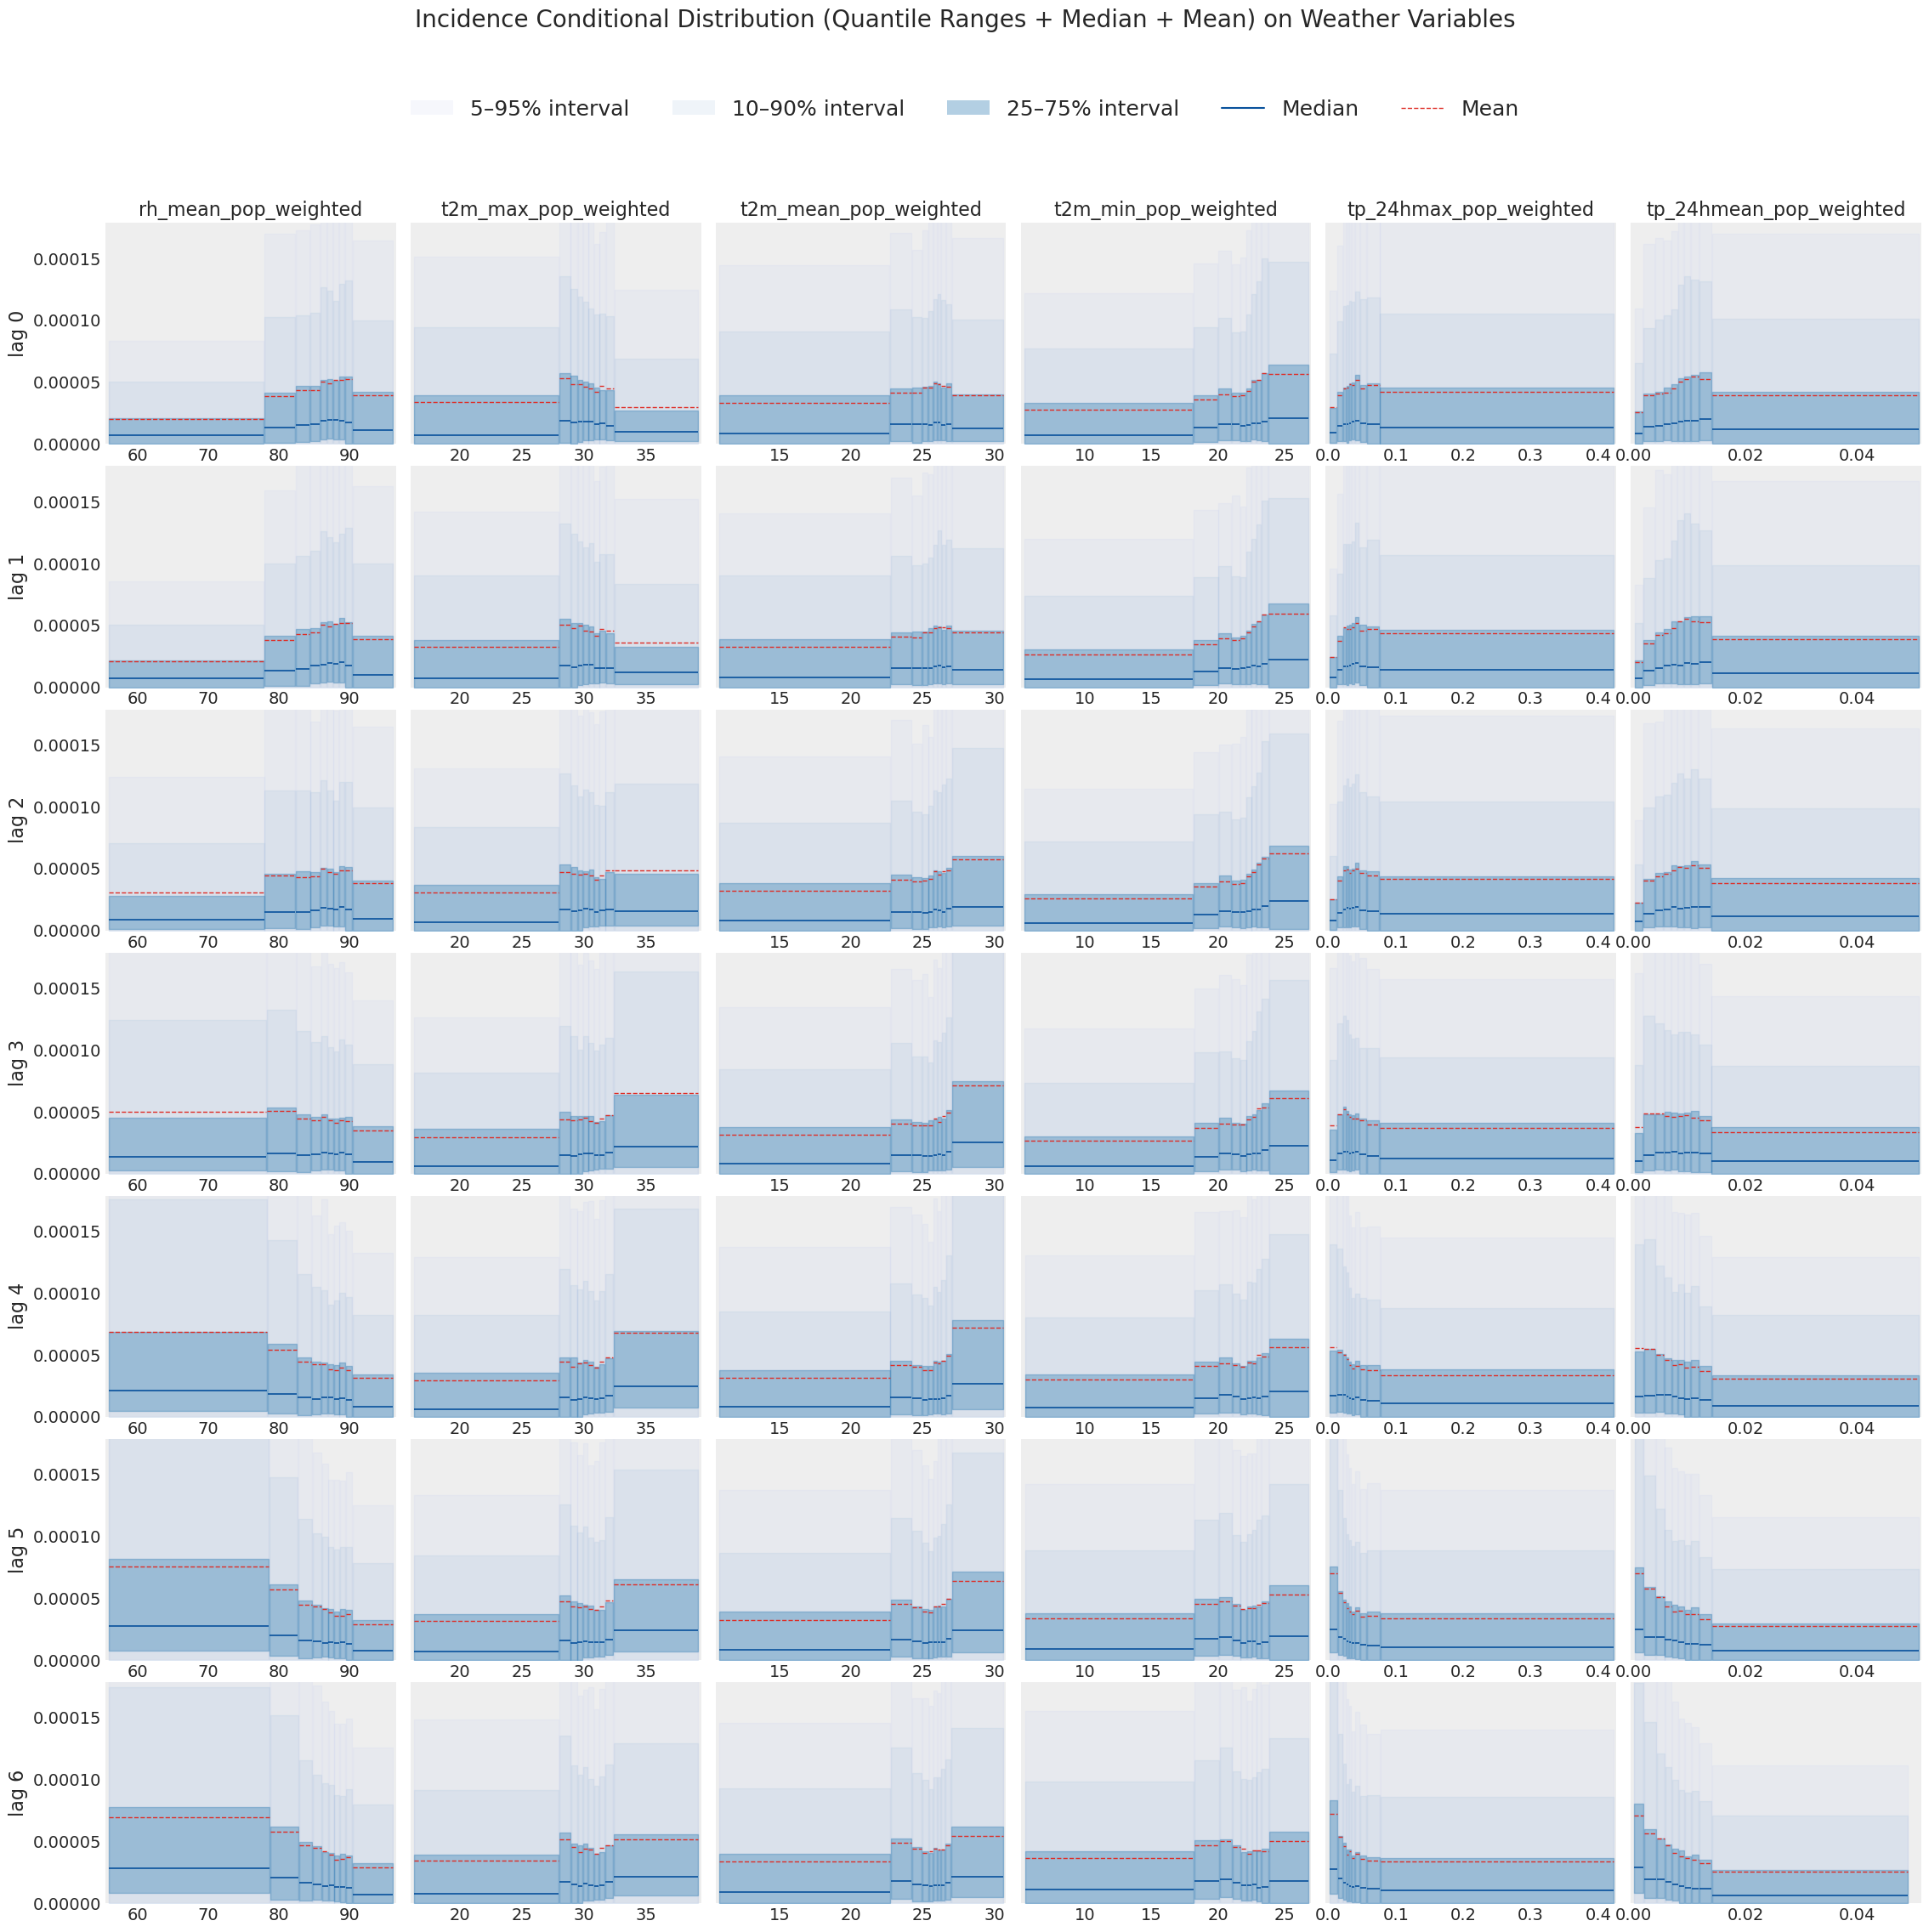

In [38]:
import numpy as np
import matplotlib.pyplot as plt

k = 10  # number of equal-frequency x bins
chunk_size = 7
n_vars = len(weather_columns) // chunk_size

# Shared x-limits per variable
xlims = {}
for j in range(n_vars):
    cols = weather_columns[j*chunk_size:(j+1)*chunk_size]
    vals = d_g0[cols].stack().dropna().values
    lo, hi = vals.min(), vals.max()
    rng = hi - lo
    if rng == 0:
        lo -= 0.1; hi += 0.1
    else:
        lo -= 0.01 * rng; hi += 0.01 * rng
    xlims[j] = (lo, hi)

# Shared y-limits
ylims = np.percentile(d_g0['rate'], [5, 95])
ylims = [np.min(d_g0['rate']), ylims[1]]

fig, axes = plt.subplots(
    chunk_size, n_vars,
    figsize=(n_vars * 3.8, chunk_size * 3.0),
    sharey=True
)

for j in range(n_vars):
    base_name = weather_columns[j * chunk_size].split('(')[0]

    for i in range(chunk_size):
        col_name = weather_columns[j * chunk_size + i]
        ax = axes[i, j]
        sub = d_g0[[col_name, 'rate']].dropna()

        if sub.shape[0] >= k * 5:

            x = sub[col_name].values
            y = sub['rate'].values

            # equal-frequency bins
            quantile_edges = np.quantile(x, np.linspace(0, 1, k + 1))
            quantile_edges = np.unique(quantile_edges)
            actual_k = len(quantile_edges) - 1

            for b in range(actual_k):
                lo_b, hi_b = quantile_edges[b]+0.00285*(np.max(x)-np.min(x)), quantile_edges[b + 1]

                if b == actual_k - 1:
                    mask = (x >= lo_b) & (x <= hi_b)
                else:
                    mask = (x >= lo_b) & (x < hi_b)

                y_bin = y[mask]
                if len(y_bin) < 5:
                    continue

                # quantiles
                q5, q10, q25, q50, q75, q90, q95 = np.percentile(
                    y_bin, [5, 10, 25, 50, 75, 90, 95]
                )

                # draw ribbons
                ax.fill_betweenx(
                    [q5, q95],
                    lo_b, hi_b,
                    alpha=0.15,
                    color=color_95
                )

                ax.fill_betweenx(
                    [q10, q90],
                    lo_b, hi_b,
                    alpha=0.15,
                    color=color_90
                )
                ax.fill_betweenx(
                    [q25, q75],
                    lo_b, hi_b,
                    alpha=0.35,
                    color=color_75
                )

                # median line
                ax.hlines(
                    q50,
                    lo_b,
                    hi_b,
                    linewidth=1.2,
                    color=median_color
                )
                # mean line
                ax.hlines(
                    y_bin.mean(),
                    lo_b,
                    hi_b,
                    linewidth=1,
                    color=mean_color,
                    linestyle='--'
                )

        ax.set_xlim(xlims[j])
        ax.set_ylim(ylims)
        ax.grid(alpha=0.0)

        if i == 0:
            ax.set_title(base_name, fontsize=16)

        if j == 0:
            ax.set_ylabel(f"lag {i}", fontsize=16)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [
    Patch(facecolor=color_95, alpha=0.15, label='5–95% interval'),
    Patch(facecolor=color_90, alpha=0.15, label='10–90% interval'),
    Patch(facecolor=color_75, alpha=0.35, label='25–75% interval'),
    Line2D([0], [0], color=median_color, lw=1.5, label='Median'),
    Line2D([0], [0], color=mean_color, lw=1, linestyle='--', label='Mean')
]

fig.legend(
    handles=legend_elements,
    loc='upper center',
    ncol=5,
    frameon=False,
    fontsize=18,
    bbox_to_anchor=(0.5, 1.04)
)
fig.suptitle("Incidence Conditional Distribution (Quantile Ranges + Median + Mean) on Weather Variables", fontsize=20, y=1.08)
plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.1)
plt.show()


Conditional curves change gradually with lag, leading to quite different shapes. This is done by dividing weather variable data into groups of the same size of data points, and plotting mean, median and quantiles on each range. Seems like relationship does change with lag.
- quantile interval sizes grow markedly for reltive humidity, possibly showing a weaker relationship.
- quantile interval sizes decrease for precipitation statistics, possibly showing a stronger relationship.

/tmp/ipykernel_2387435/3313999102.py:106: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


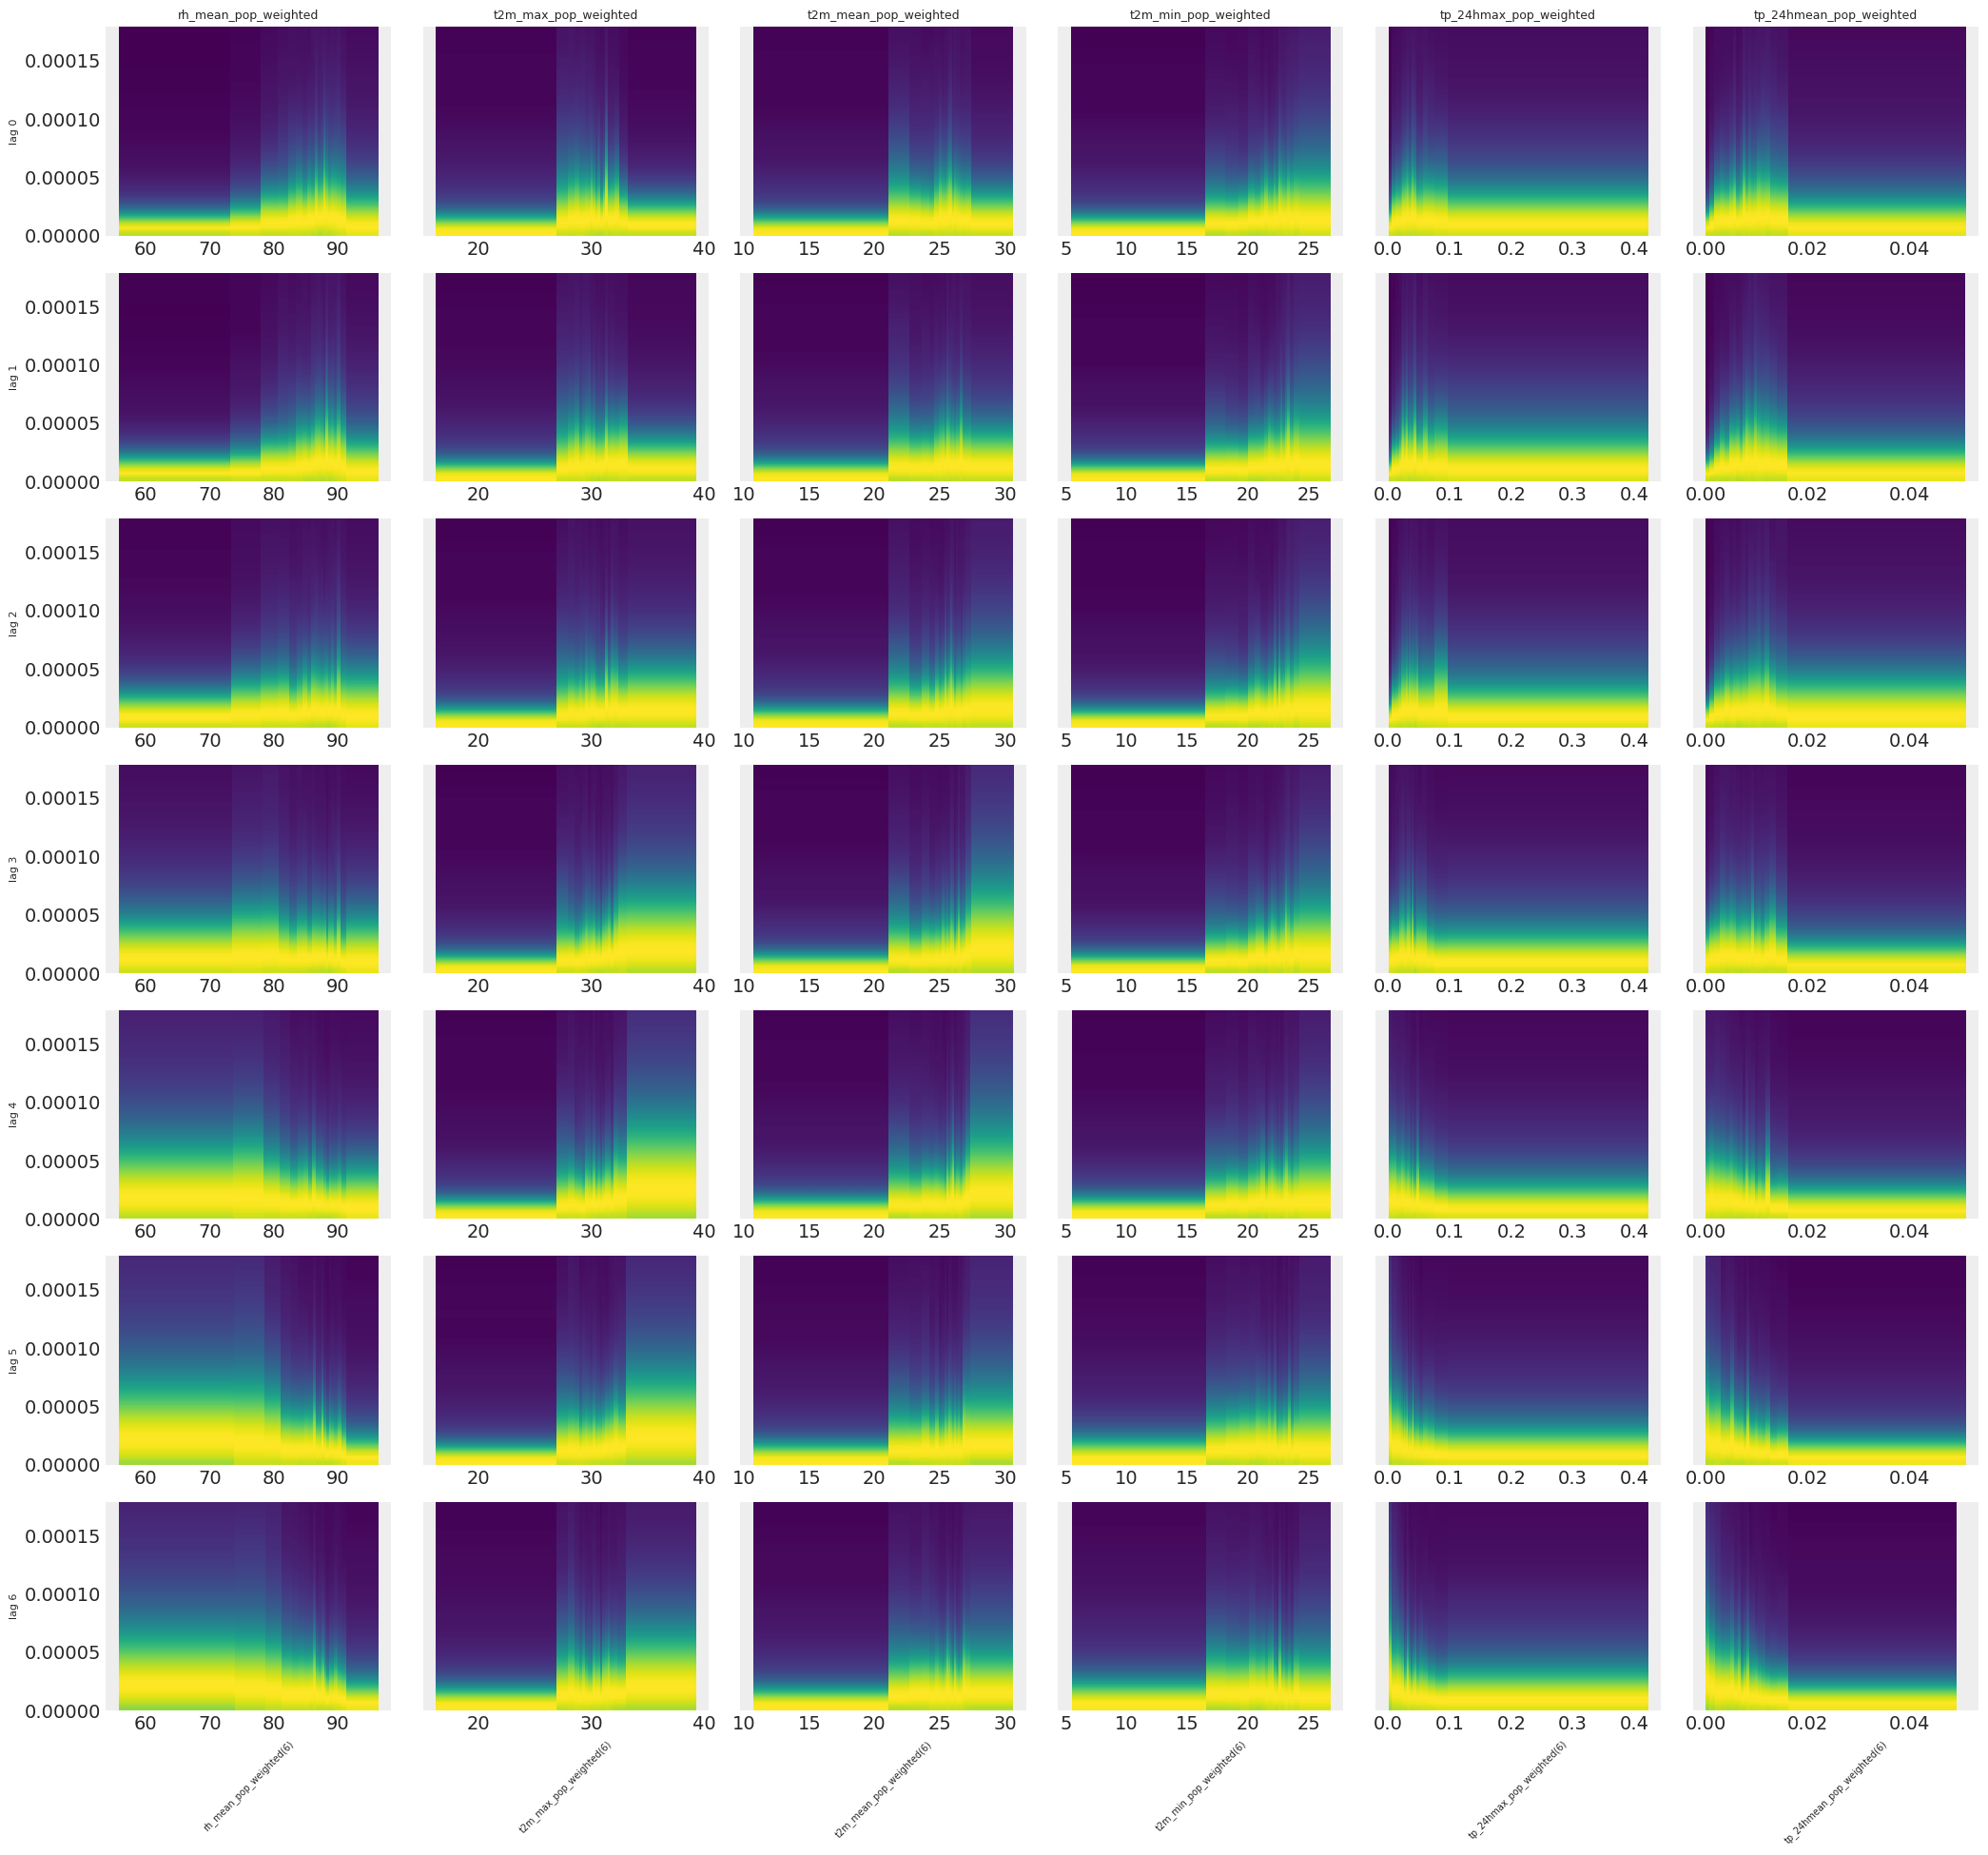

In [ ]:
from scipy.stats import gaussian_kde

k = 20

# compute shared x-limits per column
chunk_size = 7
n_vars = len(weather_columns) // chunk_size

xlims = {}
for j in range(n_vars):
    cols = weather_columns[j*chunk_size:(j+1)*chunk_size]
    vals = d_g0[cols].stack().dropna().values
    lo, hi = vals.min(), vals.max()
    rng = hi - lo
    if rng == 0:
        lo -= 0.5; hi += 0.5
    else:
        lo -= 0.05 * rng; hi += 0.05 * rng
    xlims[j] = (lo, hi)

# y grid for KDE evaluation
N_Y = 1000
ylims = np.percentile(d_g0['rate'], [5, 95])
fig, axes = plt.subplots(chunk_size, n_vars,
                         figsize=(n_vars * 3.5, chunk_size * 2.8),
                         sharey=True)

for j in range(n_vars):
    base_name = weather_columns[j * chunk_size].split('(')[0]
    for i in range(chunk_size):
        col_name = weather_columns[j * chunk_size + i]
        ax = axes[i, j]
        sub = d_g0[[col_name, 'rate']].dropna()

        if sub.shape[0] >= k * 2:
            x = sub[col_name].values
            y = sub['rate'].values

            # global y range for consistent heatmap axis
            y_lo, y_hi = y.min(), y.max()
            y_grid = np.linspace(y_lo, y_hi, N_Y)

            # split x into k quantile bins with equal point counts
            quantile_edges = np.quantile(x, np.linspace(0, 1, k + 1))
            # ensure edges are strictly increasing for display
            quantile_edges = np.unique(quantile_edges)
            actual_k = len(quantile_edges) - 1

            heatmap = np.zeros((N_Y, actual_k))
            x_centers = []
            x_widths = []

            for b in range(actual_k):
                lo_b, hi_b = quantile_edges[b], quantile_edges[b + 1]
                x_centers.append((lo_b + hi_b) / 2)
                x_widths.append(hi_b - lo_b)

                mask = (x >= lo_b) & (x <= hi_b) if b < actual_k - 1 else (x >= lo_b) & (x <= hi_b)
                # include right edge in last bin
                if b == actual_k - 1:
                    mask = (x >= lo_b) & (x <= hi_b)
                else:
                    mask = (x >= lo_b) & (x < hi_b)

                y_bin = y[mask]
                if len(y_bin) >= 3:
                    kde = gaussian_kde(y_bin, bw_method='silverman')
                    density = kde(y_grid)
                    density /= density.max()  # normalize each strip to [0,1]
                    heatmap[:, b] = density
                else:
                    heatmap[:, b] = 0

            # draw each bin as a vertical colored strip
            cmap = plt.cm.viridis
            for b in range(actual_k):
                lo_b = quantile_edges[b]
                hi_b = quantile_edges[b + 1]
                ax.imshow(
                    heatmap[:, b:b+1],
                    origin='lower',
                    aspect='auto',
                    extent=[lo_b, hi_b, y_lo, y_hi],
                    cmap=cmap,
                    vmin=0, vmax=1,
                    interpolation='bilinear'
                )

            # overlay bin boundary lines
            for edge in quantile_edges[1:-1]:
                ax.axvline(edge, color='lightgray', linewidth=0.0, alpha=0.3)

        ax.grid(alpha=0.0)
        ax.set_xlim(xlims[j])
        ax.set_ylim(ylims)
        if i == 0:
            ax.set_title(base_name, fontsize=9)
        if j == 0:
            ax.set_ylabel(f"lag {i}", fontsize=8)
        if i == chunk_size - 1:
            ax.set_xlabel(col_name, fontsize=7, rotation=45)

plt.tight_layout()
plt.show()

/tmp/ipykernel_2441170/3537758956.py:57: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


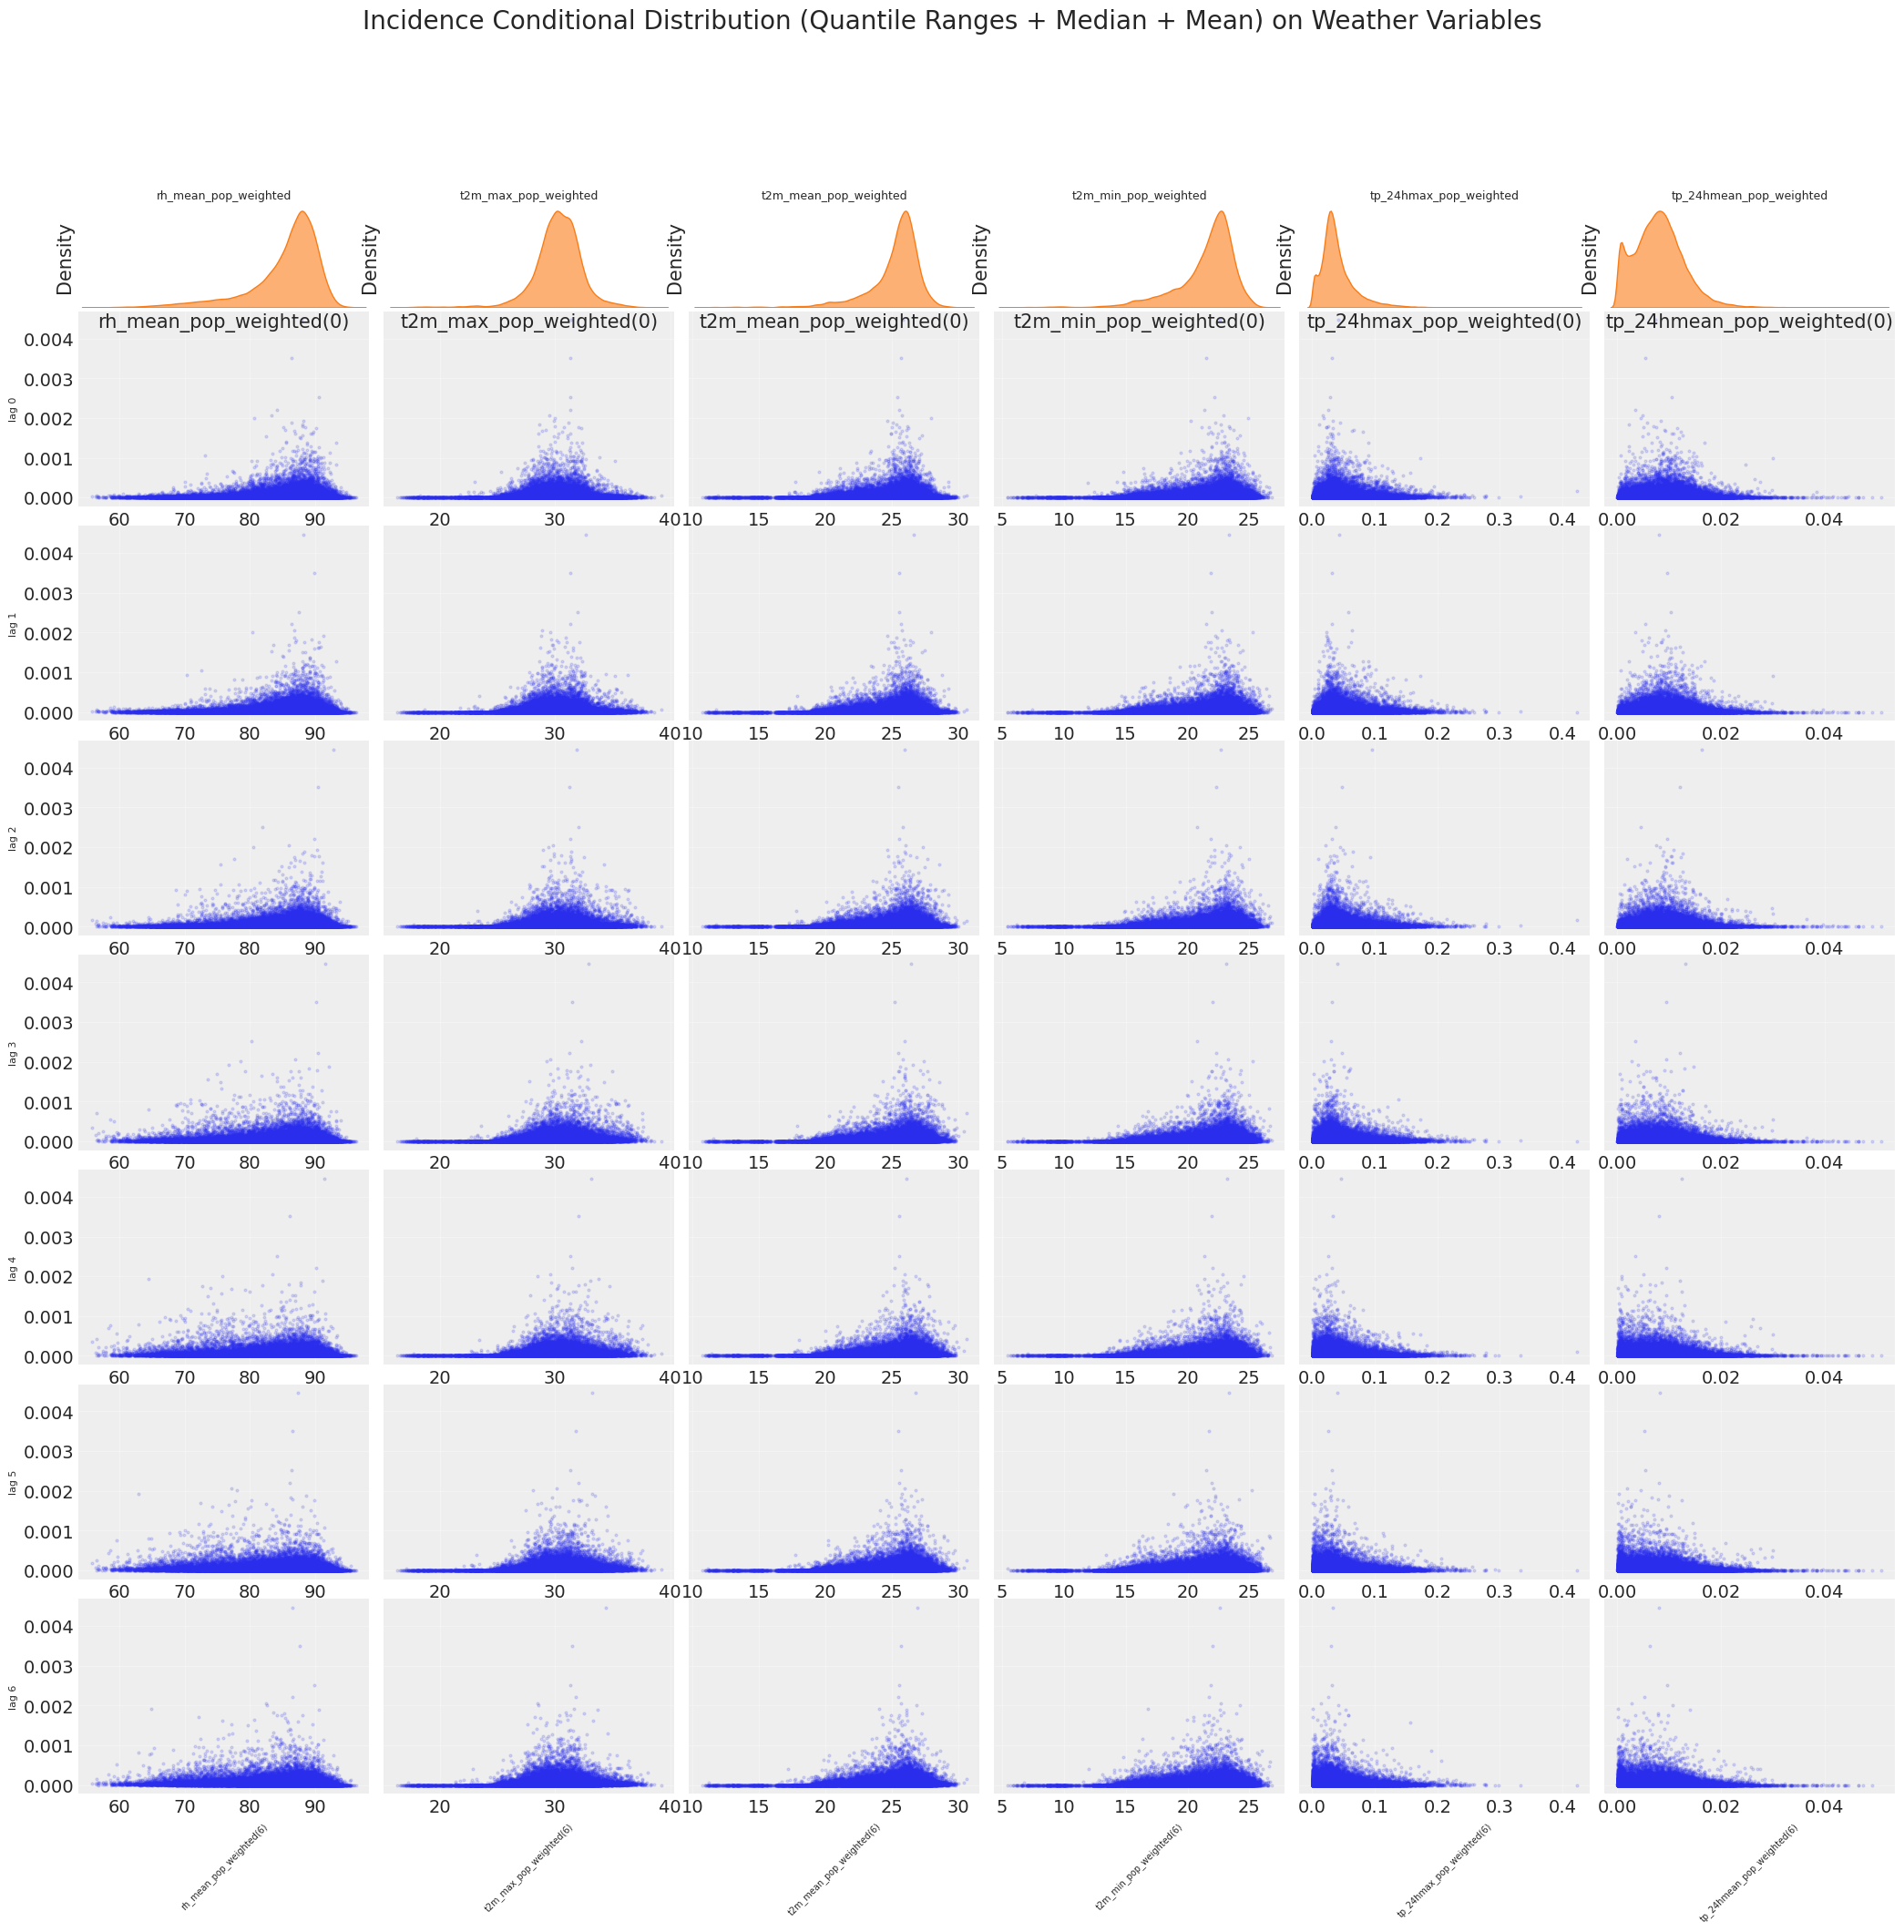

In [39]:
# compute shared x-limits per column (same limits for all lags of a variable)
chunk_size = 7
n_vars = len(weather_columns) // chunk_size

xlims = {}
for j in range(n_vars):
    cols = weather_columns[j*chunk_size:(j+1)*chunk_size]
    vals = d_g0[cols].stack().dropna().values
    lo, hi = vals.min(), vals.max()
    rng = hi - lo
    if rng == 0:
        lo -= 0.5
        hi += 0.5
    else:
        lo -= 0.05 * rng
        hi += 0.05 * rng
    xlims[j] = (lo, hi)

# plotting with fixed x-axis per column
fig, axes = plt.subplots(chunk_size, n_vars, figsize=(n_vars * 3.5, chunk_size * 2.8), sharey=True)
for j in range(n_vars):
    base_name = weather_columns[j * chunk_size].split('(')[0]
    for i in range(chunk_size):
        col_name = weather_columns[j * chunk_size + i]
        ax = axes[i, j]
        sub = d_g0[[col_name, 'rate']].dropna()
        if sub.shape[0] > 0:
            ax.scatter(sub[col_name], sub['rate'], s=4, alpha=0.15, rasterized=True)
            try:
                sns.regplot(x=col_name, y='rate', data=sub, ax=ax, scatter=False, lowess=True,
                            line_kws={'color': 'C1', 'linewidth': 1})
            except Exception:
                pass
            if sub.shape[0] >= 2 and i == 0:
                try:
                    ax_den = ax.inset_axes([0, 1.02, 1, 0.52], transform=ax.transAxes)
                    sns.kdeplot(sub[col_name], ax=ax_den, bw_adjust=0.8, fill=True, color='C1', alpha=0.6)
                    ax_den.set_xlim(ax.get_xlim())
                    ax_den.set_xticks([]); ax_den.set_yticks([])
                    ax_den.patch.set_alpha(0)
                except Exception:
                    try:
                        sns.kdeplot(sub[col_name], ax=ax, bw_adjust=0.8, color='C0', lw=1)
                        for lbl in ax.get_yticklabels():
                            lbl.set_visible(False)
                    except Exception:
                        pass
        ax.grid(alpha=0.3)
        ax.set_xlim(xlims[j])
        if i == 0:
            ax.set_title(base_name, fontsize=9)
        if j == 0:
            ax.set_ylabel(f"lag {i}", fontsize=8)
        if i == chunk_size - 1:
            ax.set_xlabel(col_name, fontsize=7, rotation=45)
fig.suptitle("Incidence Conditional Distribution (Quantile Ranges + Median + Mean) on Weather Variables", fontsize=20, y=1.08)
plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.1)
plt.show()

- pair plots on temperature do not seem to change much in lag
- pair plots on rh seem to change, flattening out to the left so that low values cause high incidence
- pair plots on tp seem to change, with some flattening and a column forming at zero (so zero tp at low lags matches with low incidence but zero tp at large lags has very spread out incidence values)
- changes are very small between adjacent lags.

---

# Clustering
- by regions (admin1 or larger region)
- by weather covariate distribution
- by incidence-weather relationship

In [30]:
# create a dictionary mapping admin1 to list of admin2 in that admin1

admin1_clusters = {}
for admin1 in data['admin1'].unique():
    admin1_clusters[admin1] = sorted(data.loc[data['admin1'] == admin1, 'admin2'].unique())

region_clusters = {}
for admin1, admin2_list in admin1_clusters.items():
    region = admin1_to_region.get(admin1, "Unknown")
    if region not in region_clusters:
        region_clusters[region] = []
    region_clusters[region].extend(admin2_list)

---

In [11]:
dw = data.copy()
dw['date'] = pd.to_datetime(dw['year'].astype(str) + '-' + dw['month'].astype(str) + '-01')

In [12]:
rolled

NameError: name 'rolled' is not defined

In [ ]:
# make sure date is datetime
dw['date'] = pd.to_datetime(dw['date'])

# sort properly
df_sorted = dw.sort_values(['admin2', 'date']).copy()

cols = weather_columns

# time-based rolling 12 within each admin2
rolled = (
    df_sorted
    .groupby('admin2')[cols].rolling(12, min_periods=12).mean()
    .reset_index(level=0, drop=True)
)

# attach back
for c in cols:
    df_sorted[f'{c}_roll12'] = rolled[c].values

data_roll12 = df_sorted
data_roll12.dropna(inplace=True)

In [ ]:
ab = dw.loc[dw['admin2'] == 'ACEH BARAT', weather_columns].reset_index(drop=True)
ab_roll = data_roll12.loc[data_roll12['admin2'] == 'ACEH BARAT', [c for c in data_roll12.columns if c.endswith('_roll12')]].reset_index(drop=True)
ab.shape, ab_roll.shape

((108, 42), (97, 42))

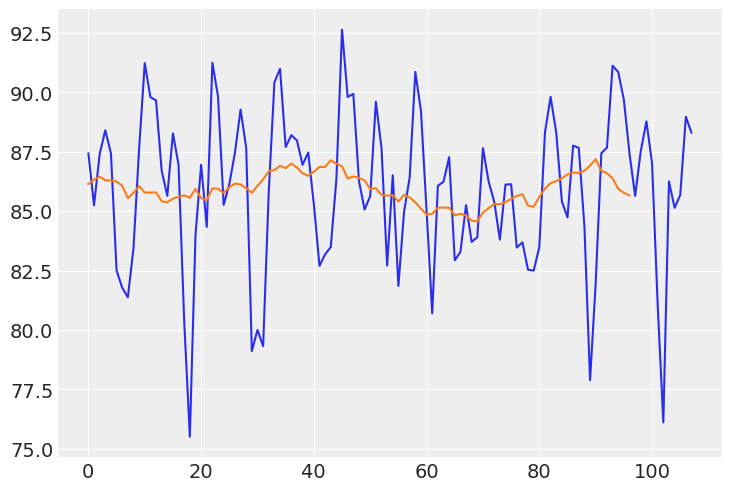

In [ ]:
plt.plot(ab['rh_mean_pop_weighted(0)'])
plt.plot(ab_roll['rh_mean_pop_weighted(0)_roll12'])

In [ ]:
# compute 12-month rolling averages of weather_columns within each admin2 using the date column
df_sorted = dw.sort_values(['admin2', 'date']).copy()
cols = weather_columns

# time-based 12-month window (approx 365 days); falls back to 12-row window if you prefer row-based use .rolling(12)
rolled = df_sorted.groupby('admin2').rolling(window='365D', on='date', min_periods=1)[cols].mean().reset_index(level=0, drop=True)

# attach results as new columns with suffix _roll12
for c in cols:
    df_sorted[f'{c}_roll12'] = rolled[c].values

# assign to a new variable to avoid overwriting original data
data_roll12 = df_sorted

# quick check
data_roll12[[ 'admin2', 'date' ] + [f'{c}_roll12' for c in cols]].head()

,admin2,date,rh_mean_pop_weighted(0)_roll12,rh_mean_pop_weighted(1)_roll12,rh_mean_pop_weighted(2)_roll12,rh_mean_pop_weighted(3)_roll12,rh_mean_pop_weighted(4)_roll12,rh_mean_pop_weighted(5)_roll12,rh_mean_pop_weighted(6)_roll12,t2m_max_pop_weighted(0)_roll12,...,tp_24hmax_pop_weighted(4)_roll12,tp_24hmax_pop_weighted(5)_roll12,tp_24hmax_pop_weighted(6)_roll12,tp_24hmean_pop_weighted(0)_roll12,tp_24hmean_pop_weighted(1)_roll12,tp_24hmean_pop_weighted(2)_roll12,tp_24hmean_pop_weighted(3)_roll12,tp_24hmean_pop_weighted(4)_roll12,tp_24hmean_pop_weighted(5)_roll12,tp_24hmean_pop_weighted(6)_roll12
648,ACEH BARAT,2016-01-01,87.441918,88.434737,90.788559,89.655487,88.277261,86.732706,85.291128,31.263310,...,0.225384,0.047743,0.078872,0.009708,0.016928,0.014674,0.021468,0.019611,0.007958,0.010444
649,ACEH BARAT,2016-02-01,86.345507,87.938327,89.611648,90.222023,88.966374,87.504983,86.011917,31.518812,...,0.240327,0.136564,0.063308,0.007304,0.013318,0.015801,0.018071,0.020539,0.013784,0.009201
650,ACEH BARAT,2016-03-01,86.698814,87.041917,88.888405,89.626261,89.573769,88.221818,86.767031,31.496757,...,0.182162,0.176133,0.117333,0.007864,0.010512,0.013770,0.017690,0.018584,0.016346,0.012671
651,ACEH BARAT,2016-04-01,87.126217,87.132795,87.978577,89.080175,89.289011,88.863503,87.489145,31.320801,...,0.177838,0.148558,0.151817,0.008909,0.010130,0.011553,0.015695,0.018170,0.015928,0.014870
652,ACEH BARAT,2016-05-01,87.188114,87.387921,87.863948,88.313959,88.919592,88.777750,88.149028,31.458100,...,0.163900,0.151819,0.134620,0.009720,0.010513,0.011039,0.013536,0.016478,0.016128,0.014831


In [ ]:
dw

,admin1,admin2,year,month,cases,ONI,t2m_mean_unweighted(0),t2m_mean_pop_weighted(0),t2m_min_unweighted(0),t2m_min_pop_weighted(0),...,urban_surveillance_nonweighted,urban_surveillance_pop_weighted,density_unweighted,density_pop_weighted,urban_density_unweighted,urban_density_pop_weighted,urbanisation_nonweighted_std,urbanisation_pop_weighted_std,ONI_std,date
0,ACEH,SIMEULUE,2016,1,1.0,2.48,27.17922,27.197840,24.47756,24.526417,...,0.774953,0.768781,42.316379,715.475930,296.269231,1066.646631,-0.77511,-1.449924,2.992386,2016-01-01
1,ACEH,SIMEULUE,2016,2,8.0,2.14,27.36236,27.382226,24.75063,24.775451,...,0.774953,0.768781,42.316379,715.475930,296.269231,1066.646631,-0.77511,-1.449924,2.586619,2016-02-01
2,ACEH,SIMEULUE,2016,3,9.0,1.58,27.37810,27.401347,24.88680,24.928477,...,0.774953,0.768781,42.316379,715.475930,296.269231,1066.646631,-0.77511,-1.449924,1.918299,2016-03-01
3,ACEH,SIMEULUE,2016,4,14.0,0.94,27.39373,27.415193,25.11874,25.147523,...,0.774953,0.768781,42.316379,715.475930,296.269231,1066.646631,-0.77511,-1.449924,1.154503,2016-04-01
4,ACEH,SIMEULUE,2016,5,4.0,0.39,27.50067,27.520510,25.18392,25.223199,...,0.774953,0.768781,42.316379,715.475930,296.269231,1066.646631,-0.77511,-1.449924,0.498117,2016-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55507,PAPUA,KOTA JAYAPURA,2024,8,8.0,-0.11,25.74790,25.918357,22.70297,22.875526,...,0.843776,0.874028,424.647959,14869.435665,3627.737374,17003.582738,-0.47457,1.107569,-0.098598,2024-08-01
55508,PAPUA,KOTA JAYAPURA,2024,9,0.0,-0.21,26.05120,26.183588,22.68896,22.831706,...,0.843776,0.874028,424.647959,14869.435665,3627.737374,17003.582738,-0.47457,1.107569,-0.217941,2024-09-01
55509,PAPUA,KOTA JAYAPURA,2024,10,24.0,-0.26,25.86794,26.034049,22.81628,22.964368,...,0.843776,0.874028,424.647959,14869.435665,3627.737374,17003.582738,-0.47457,1.107569,-0.277613,2024-10-01
55510,PAPUA,KOTA JAYAPURA,2024,11,57.0,-0.37,26.09180,26.242261,22.76202,22.958716,...,0.843776,0.874028,424.647959,14869.435665,3627.737374,17003.582738,-0.47457,1.107569,-0.408890,2024-11-01


In [ ]:
dw = data[weather_columns]

dw_roll = dw.rolling(12, min_periods=1).mean()

dw = np.array(dw)
dw_roll = np.array(dw_roll)

In [ ]:
dw.shape, dw_roll.shape

((54042, 42), (54042, 42))

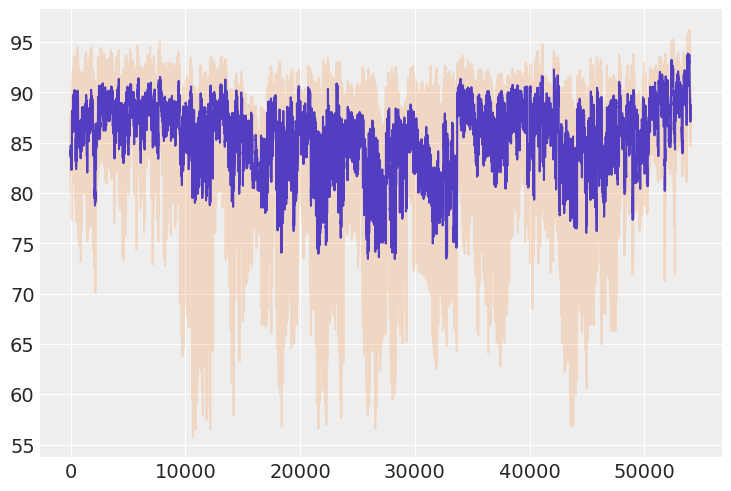

In [ ]:
plt.plot(dw_roll[:, 0])
plt.plot(dw[:, 0], alpha=0.2)
plt.show()